In [16]:
# Essential Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import pickle  # For saving models

In [17]:
#  Scikit-learn Imports
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [18]:
# ==============================================================
# LOAD DATASET
# ==============================================================
print("🔹 Loading dataset...")
df = pd.read_csv("/kaggle/input/new-data/generate_energy.csv")

# 🔹 Drop unnecessary columns
df.drop(columns=["timestamp"], inplace=True)

# 🔹 Remove unnamed index columns (if any exist)
df = df.loc[:, ~df.columns.str.contains("Unnamed")]

🔹 Loading dataset...


In [19]:
# ==============================================================
# FEATURE ENGINEERING
# ==============================================================

# 🔹 Define feature columns (existing & lag features)
feature_cols = [
    "hour", "day_of_week", "month",  # Time-based features
    "demand_prev_hour", "demand_prev_day", "demand_rolling_7d", "demand_rolling_24h"  # Lag-based features
]

# 🔹 Define features (X) and target variable (y)
X = df[feature_cols].copy()  # Copying to avoid modifying the original DataFrame
y = df["load_demand"]

# 🔹 Create interaction features to reduce feature dependency
X["hour_demand"] = X["hour"] * X["demand_prev_day"]

In [20]:
# ==============================================================
# TRAIN-TEST SPLIT
# ==============================================================

print("🔹 Splitting dataset into train, validation, and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)


🔹 Splitting dataset into train, validation, and test sets...


In [21]:
# ==============================================================
# DEFINE MODEL PARAMETERS
# ==============================================================

print("🔹 Defining hyperparameter search spaces...")

# Random Forest (Fixed Hyperparameters)
rf_params = {
    "n_estimators": [150],
    "max_depth": [10],  # Prevents deep trees
    "max_features": ["sqrt"],  # Uses sqrt(#features) per tree
    "min_samples_split": [5],  # Controls tree splitting
    "min_samples_leaf": [4],  # Prevents small splits
}

# XGBoost (Randomized Search)
xgb_param_dist = {
    "n_estimators": [100, 200, 300],  
    "max_depth": [4, 6, 8],  
    "learning_rate": [0.01, 0.05, 0.1],  
    "subsample": [0.6, 0.8, 1.0],  
    "colsample_bytree": [0.5, 0.7, 1.0],  
    "alpha": [0, 0.5, 1.0],  
    "lambda": [0, 1, 5],  
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

🔹 Defining hyperparameter search spaces...


In [22]:
# ==============================================================
# TRAIN MODELS (GRID & RANDOM SEARCH)
# ==============================================================

print("🔹 Training models...")

# 🔹 Random Forest with Grid Search
rf_grid = GridSearchCV(
    RandomForestRegressor(random_state=42), rf_params, cv=cv, 
    scoring="neg_root_mean_squared_error", n_jobs=-1
)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# 🔹 XGBoost with Randomized Search
xgb_random = RandomizedSearchCV(
    XGBRegressor(objective="reg:squarederror", random_state=42), xgb_param_dist, 
    cv=cv, scoring="neg_root_mean_squared_error", n_iter=10, n_jobs=-1, random_state=42
)
xgb_random.fit(X_train, y_train)
best_xgb = xgb_random.best_estimator_

🔹 Training models...


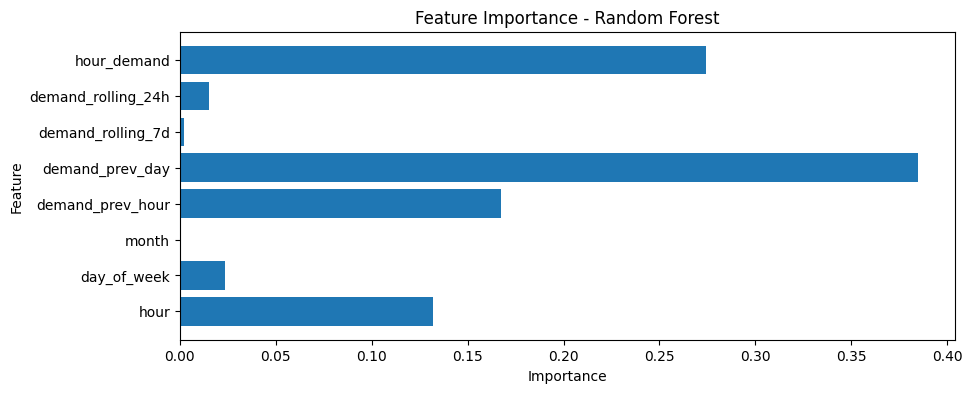

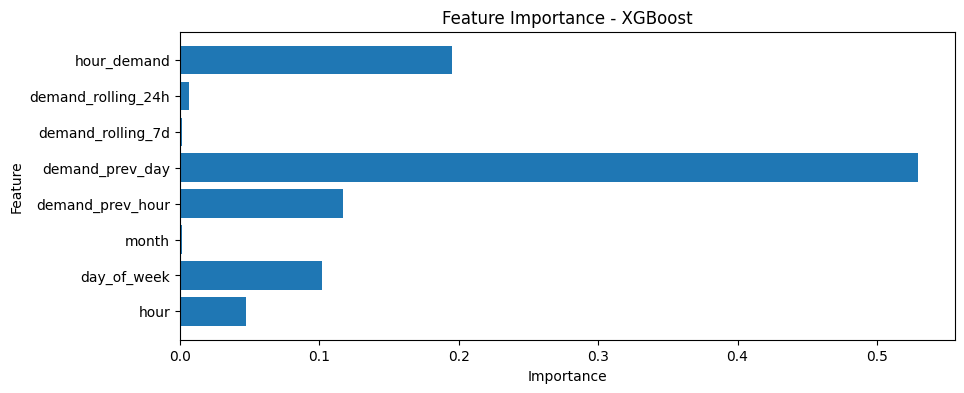

In [23]:
# ==============================================================
# FEATURE IMPORTANCE ANALYSIS
# ==============================================================

def plot_feature_importance(model, X_train, title):
    """Plots feature importance for the given model."""
    plt.figure(figsize=(10, 4))
    feature_names = X_train.columns
    importances = model.feature_importances_

    # Check if feature names and importances match
    if len(importances) != len(feature_names):
        print(f"⚠️ Feature mismatch: {len(importances)} importances, {len(feature_names)} features")
        return  

    plt.barh(feature_names, importances)
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.title(title)
    plt.show()

# 🔹 Plot feature importance
plot_feature_importance(best_rf, X_train, "Feature Importance - Random Forest")
plot_feature_importance(best_xgb, X_train, "Feature Importance - XGBoost")


🔹 XGBoost Performance:
   📉 MAE  = 2.9598
   🏆 RMSE = 4.1221
   📊 R²   = 0.9822


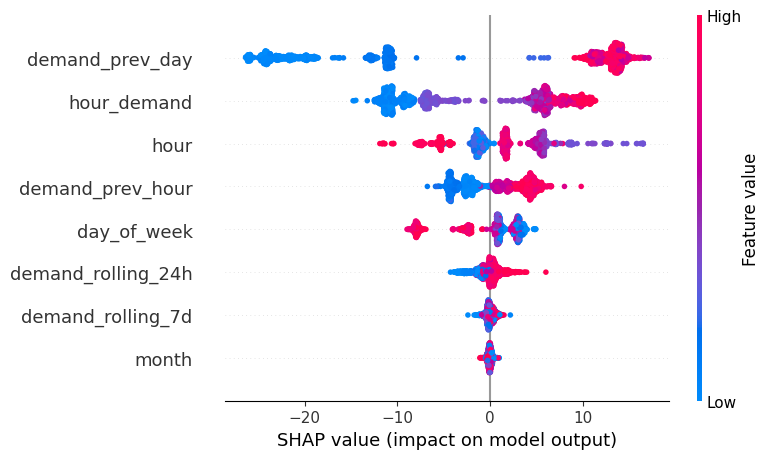


🔹 Random Forest Performance:
   📉 MAE  = 2.9003
   🏆 RMSE = 4.0327
   📊 R²   = 0.9830


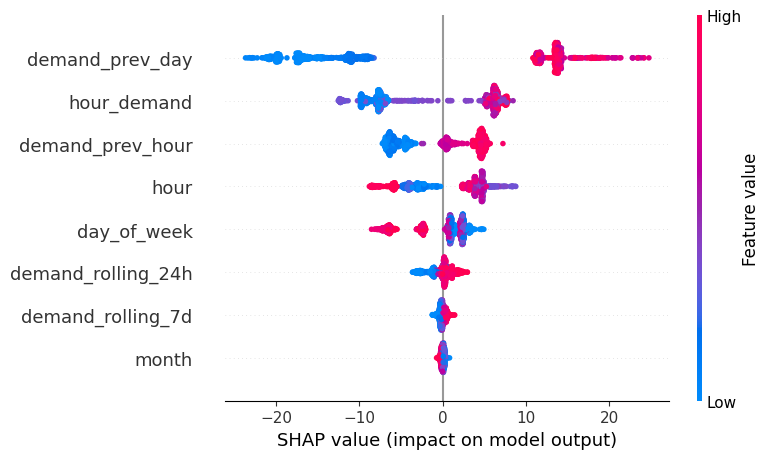

In [24]:
# ==============================================================
# 7️⃣ EVALUATE MODELS
# ==============================================================

def evaluate_models(models, X_test, y_test):
    """
    Evaluate models using RMSE, MAE, R², and SHAP explanations.
    """
    results = {}

    for name, model in models.items():
        y_pred = model.predict(X_test)

        metrics = {
            "MAE": mean_absolute_error(y_test, y_pred),
            "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
            "R²": r2_score(y_test, y_pred),
        }

        results[name] = metrics

        print(f"\n🔹 {name} Performance:")
        print(f"   📉 MAE  = {metrics['MAE']:.4f}")
        print(f"   🏆 RMSE = {metrics['RMSE']:.4f}")
        print(f"   📊 R²   = {metrics['R²']:.4f}")

        # 🔹 SHAP Summary Plot
        try:
            explainer = shap.Explainer(model)
            shap_values = explainer(X_test)
            shap.summary_plot(shap_values, X_test)  # Show summary plot

        except Exception as e:
            print(f"⚠️ SHAP could not be computed for {name}: {e}")

    return results

# 🔹 Evaluate trained models
models = {"XGBoost": best_xgb, "Random Forest": best_rf}
results = evaluate_models(models, X_test, y_test)

In [25]:

# ==============================================================
# SAVE MODELS
# ==============================================================
def save_model(model, filename):
    """Save trained model to disk."""
    with open(filename, "wb") as f:
        pickle.dump(model, f)
    print(f"✅ Model saved: {filename}")

save_model(best_rf, "random_forest_model.pkl")
save_model(best_xgb, "xgboost_model.pkl")

✅ Model saved: random_forest_model.pkl
✅ Model saved: xgboost_model.pkl
